In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import tqdm
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

# Motivation

In [2]:
data = pd.read_csv(
    "motivating_data/Surgery Treatment.csv",
    parse_dates=["CRD", "DATE_BOOKING_MADE", "TCI_DATE"],
    date_format="%d-%b-%y",
)

In [3]:
data["PRIORITY_TYPE_c"] = ["r" if p == "U" else "b" for p in data["PRIORITY_TYPE"]]

In [4]:
data["CRD_rank"] = data["CRD"].rank()
data["TCI_DATE_rank"] = data["TCI_DATE"].rank()

In [5]:
data

,WALISID,CRD,DATE_BOOKING_MADE,TCI_DATE,PRIORITY_TYPE,CONSULTANT,PRIORITY_TYPE_c,CRD_rank,TCI_DATE_rank
0,5947838,2021-01-04,2021-01-18,2021-02-25,U,2602700,r,1.0,20.0
1,5947185,2021-01-06,2021-01-06,2021-01-21,U,2602700,r,2.5,3.0
2,5947448,2021-01-06,2021-01-07,2021-01-21,U,2602700,r,2.5,3.0
3,5947596,2021-01-07,2021-01-08,2021-01-21,U,2602700,r,4.0,3.0
4,5948015,2021-01-11,2021-01-18,2021-01-27,U,3730335,r,5.0,7.5
...,...,...,...,...,...,...,...,...,...
164,6015148,2021-12-01,2021-12-01,2021-12-31,U,3730335,r,165.0,167.0
165,6017561,2021-12-10,2021-12-10,2021-12-31,U,3730335,r,166.0,167.0
166,6018199,2021-12-14,2021-12-17,2021-12-31,U,3730335,r,167.0,167.0
167,6020035,2021-12-22,2021-12-22,2021-12-31,U,3730335,r,168.5,167.0


In [6]:
data["overtakes"] = data["TCI_DATE_rank"] - data["CRD_rank"]
data["bumped_down"] = data["overtakes"] > 0
data["wait"] = (data["TCI_DATE"] - data["CRD"]).apply(lambda x: x.days)
num_down = data["bumped_down"].value_counts()

In [7]:
data["overtakes"].max()

79.5

In [8]:
np.linspace(-19, 81, 26)

array([-19., -15., -11.,  -7.,  -3.,   1.,   5.,   9.,  13.,  17.,  21.,
        25.,  29.,  33.,  37.,  41.,  45.,  49.,  53.,  57.,  61.,  65.,
        69.,  73.,  77.,  81.])

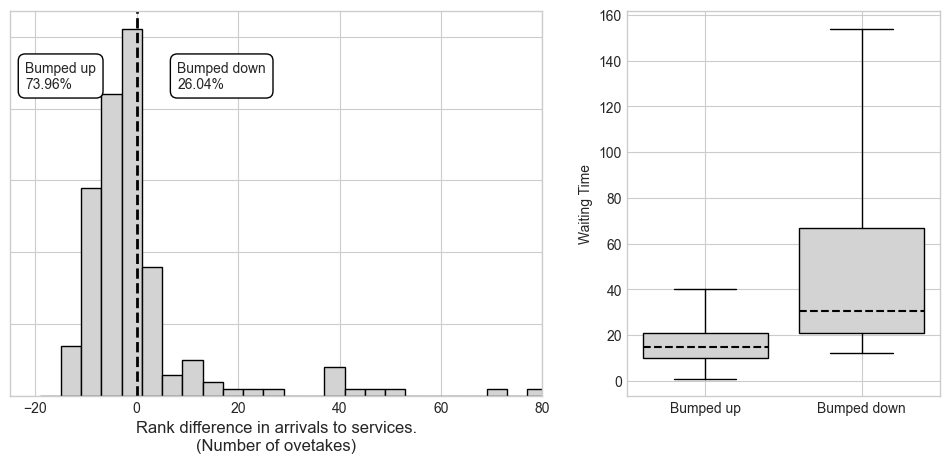

In [9]:
gs_kw = dict(width_ratios=[1.7, 1])
fig, axarr = plt.subplots(1, 2, gridspec_kw=gs_kw, figsize=(12, 5))
axarr[0].hist(
    data["overtakes"],
    edgecolor="black",
    color="lightgrey",
    bins=np.linspace(-19, 81, 26),
)
axarr[0].set_xlabel(
    "Rank difference in arrivals to services.\n(Number of ovetakes)", fontsize=12
)
axarr[0].set_yticklabels([])
ymin, ymax = axarr[0].get_ylim()
axarr[0].vlines(
    x=0, ymin=ymin, ymax=ymax, color="black", linewidth=2, linestyle="dashed"
)
axarr[0].set_ylim(ymin, ymax)
axarr[0].set_xlim(-25, 80)
axarr[0].text(
    -22,
    ymax * 0.8,
    f"Bumped up\n{round((num_down / num_down.sum())[False] * 100, 2)}%",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)
axarr[0].text(
    8,
    ymax * 0.8,
    f"Bumped down\n{round((num_down / num_down.sum())[True] * 100, 2)}%",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

medianprops = dict(linestyle="dashed", linewidth=1.5, color="black")
bplot = axarr[1].boxplot(
    [data[~data["bumped_down"]]["wait"], data[data["bumped_down"]]["wait"]],
    widths=0.8,
    whis=(0, 100),
    patch_artist=True,
    medianprops=medianprops,
)
for patch in bplot["boxes"]:
    patch.set_facecolor("lightgrey")

axarr[1].set_xticklabels(["Bumped up", "Bumped down"])
axarr[1].set_ylabel("Waiting Time")
fig.savefig("../tex/img/motivating_overtakes.pdf")

# Validation

In [10]:
import math

rate = len(data) / 365
poisson = [(rate**k) * math.exp(-rate) / math.factorial(k) for k in range(6)]

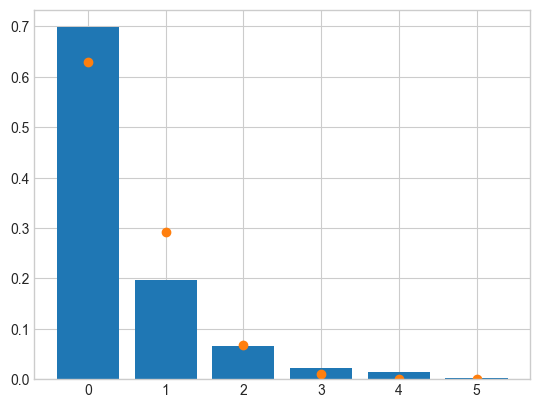

In [11]:
counts = data["CRD"].value_counts()
zero_count = 365 - len(counts)
heights = [zero_count] + [counts.value_counts()[i] for i in range(1, 6)]
heights = [h / sum(heights) for h in heights]
plt.bar(x=range(6), height=heights)
plt.scatter(x=range(6), y=poisson);

In [12]:
import models

In [13]:
def compare_model_with_real(ax, theta12, theta21, leg=False):
    ax.hist(
        data["overtakes"],
        edgecolor="black",
        color="lightgrey",
        bins=np.linspace(-19, 81, 26),
        density=True,
        alpha=0.6,
        label="Surgical data",
    )
    ax.set_xlabel("Rank difference in arrivals to services.", fontsize=8)
    ax.set_yticklabels([])
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=0, ymin=ymin, ymax=ymax, color="black", linewidth=2, linestyle="dashed")
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-25, 80)
    cmap = matplotlib.colormaps["viridis"]

    n_trials = 5

    Q = models.build_and_run_simulation(
        num_classes=2,
        num_servers=1,
        arrival_rates=[rate, 1 / 1000000000000000],
        service_rates=[0.5, 0.5],
        class_change_rate_matrix=[[None, theta12], [theta21, None]],
        max_simulation_time=365 * ((2 * n_trials) + 1),
        progress_bar=False,
    )
    recs = pd.DataFrame(Q.get_all_records())

    overtakes = []
    for trial in range(n_trials):
        recs_t = recs[
            (recs["arrival_date"] >= (365 * ((2 * trial) + 1)))
            & (recs["arrival_date"] <= (365 * ((2 * trial) + 2)))
        ].copy()
        recs_t["arrival_rank"] = recs_t["arrival_date"].rank()
        recs_t["service_start_rank"] = recs_t["service_start_date"].rank()
        recs_t["overtakes"] = recs_t["service_start_rank"] - recs_t["arrival_rank"]
        overtakes.extend(list(recs_t["overtakes"]))

    sns.kdeplot(overtakes, color=cmap(0.5), fill=True, ax=ax, label="Model")
    ax.set_ylabel("")
    W = scipy.stats.wasserstein_distance(overtakes, data["overtakes"])

    if theta21 is None:
        theta21a = 0
    else:
        theta21a = theta21
    annotation = rf"$\theta_{{12}} = {theta12}$"
    annotation += "\n"
    annotation += rf"$\theta_{{21}} = {theta21a}$"
    annotation += "\n"
    annotation += rf"$W = {round(W, 3)}$"
    ax.annotate(
        annotation,
        (0.75, 0.75),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )
    if leg:
        ax.legend(
            ncols=2, fontsize=16, bbox_to_anchor=(-0.03, 1.1, 1.0, 0.102), frameon=True
        )
    return ax

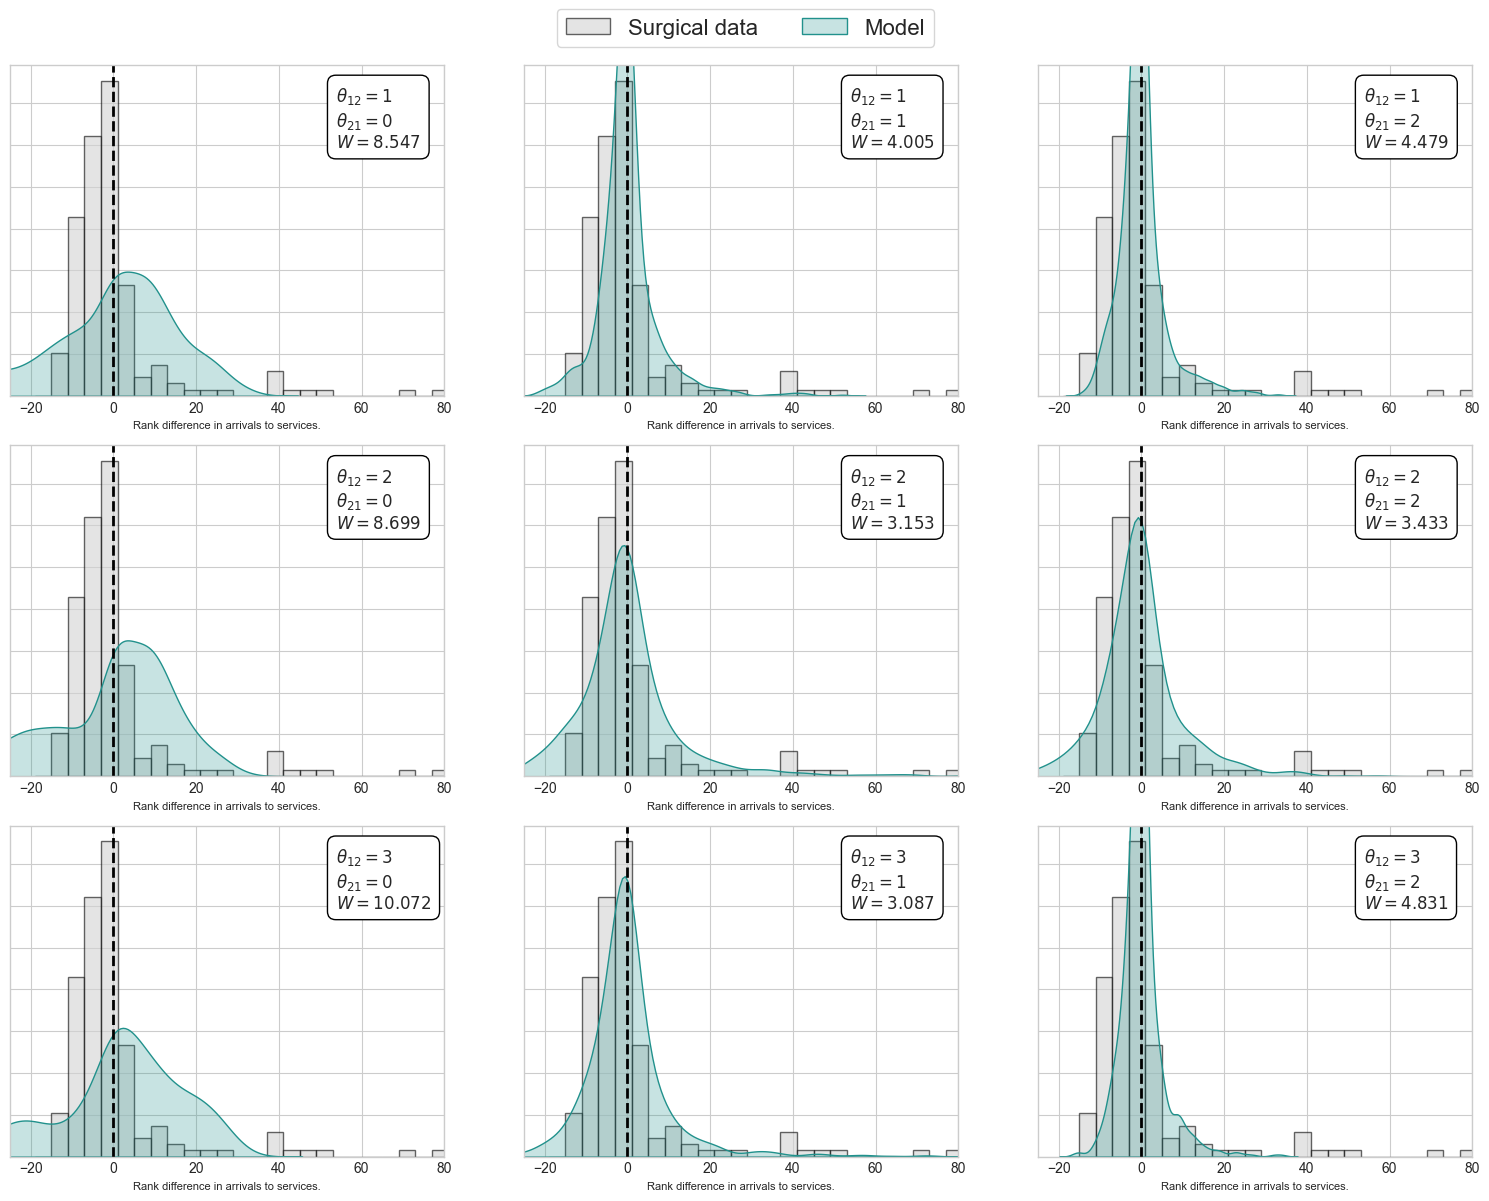

In [14]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 12))
compare_model_with_real(axarr[0][0], 1, None)
compare_model_with_real(axarr[0][1], 1, 1, leg=True)
compare_model_with_real(axarr[0][2], 1, 2)
compare_model_with_real(axarr[1][0], 2, None)
compare_model_with_real(axarr[1][1], 2, 1)
compare_model_with_real(axarr[1][2], 2, 2)
compare_model_with_real(axarr[2][0], 3, None)
compare_model_with_real(axarr[2][1], 3, 1)
compare_model_with_real(axarr[2][2], 3, 2)
plt.tight_layout()
fig.savefig("../tex/img/fitting_theta.pdf")